## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [1]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.1+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

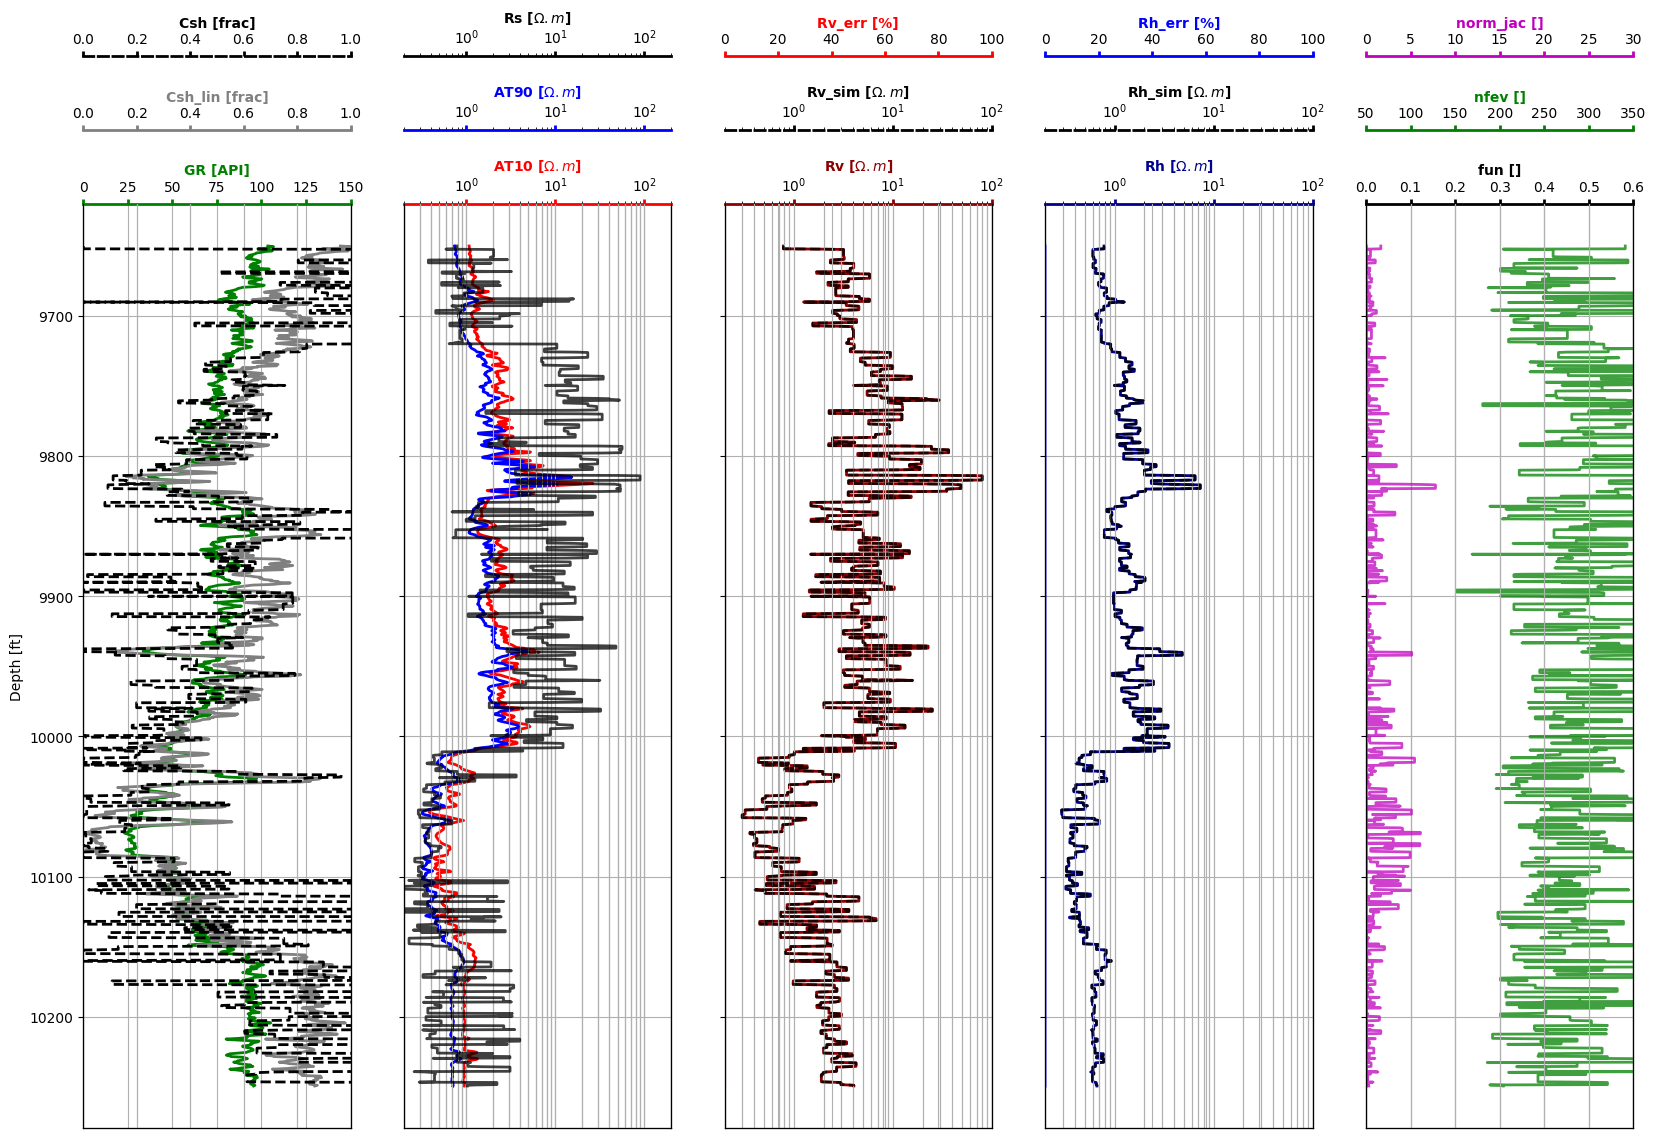

In [3]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

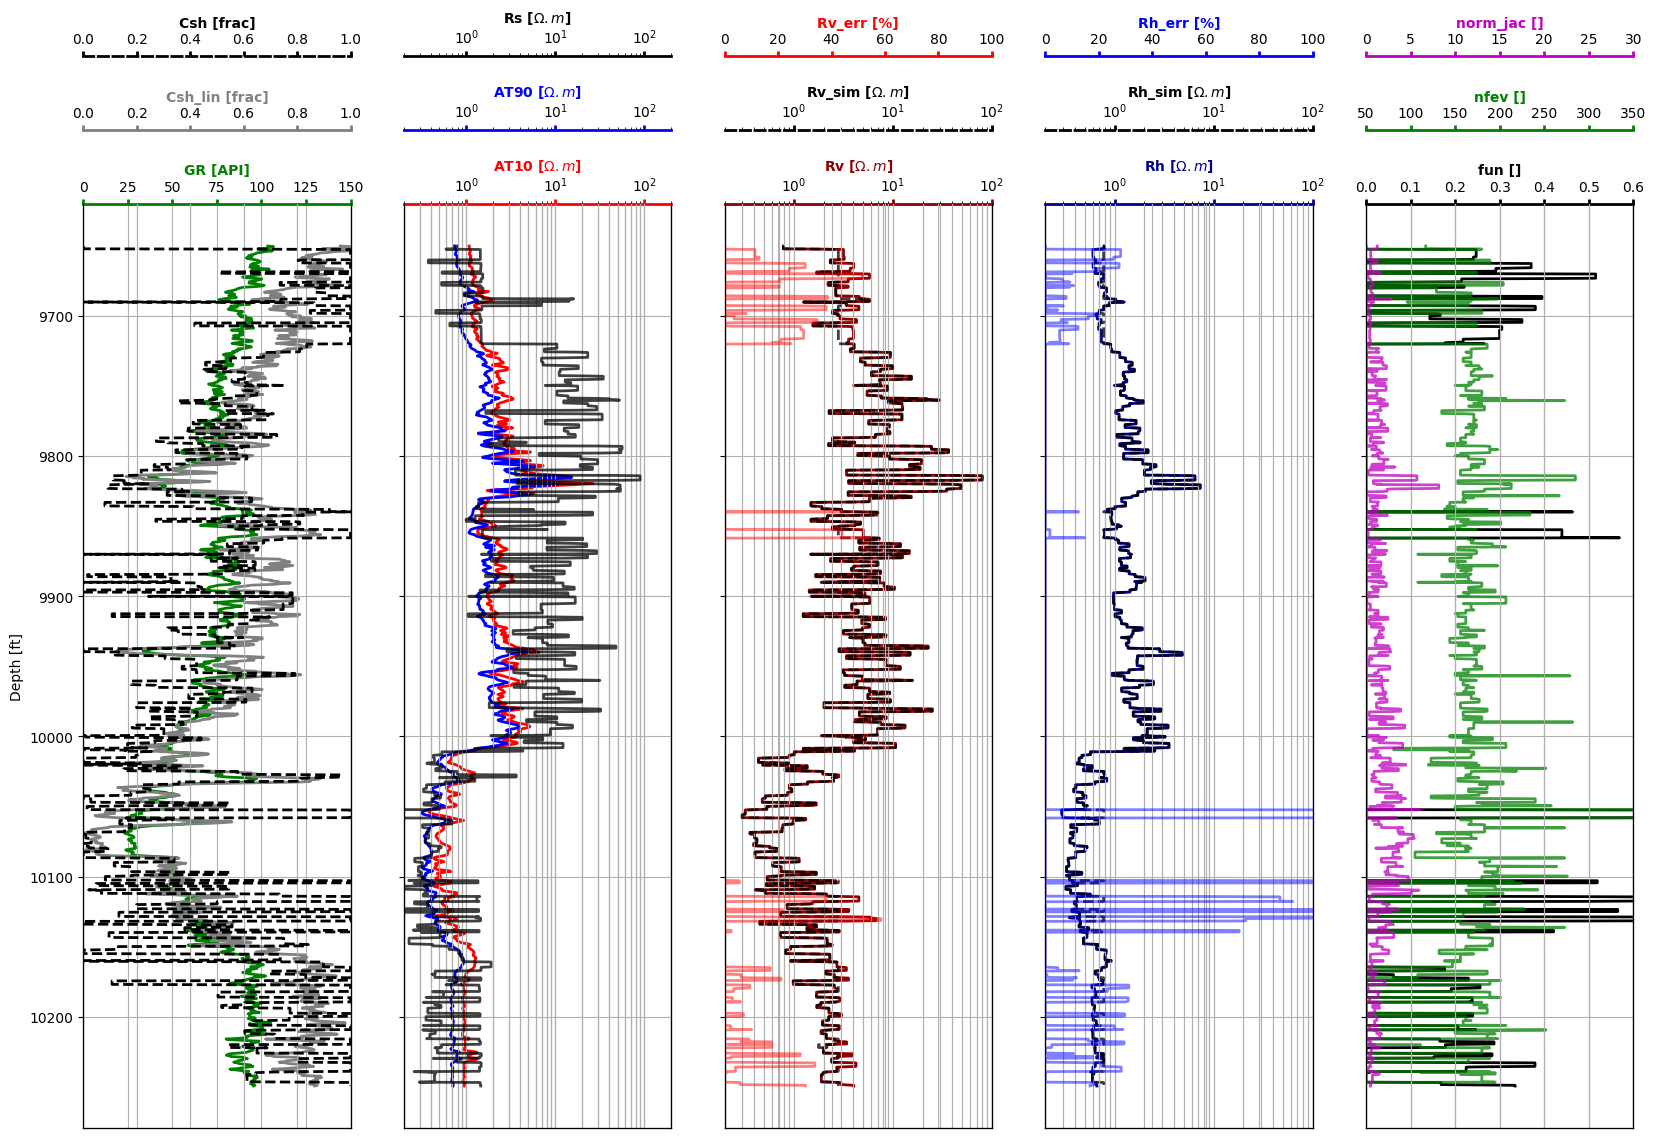

In [4]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

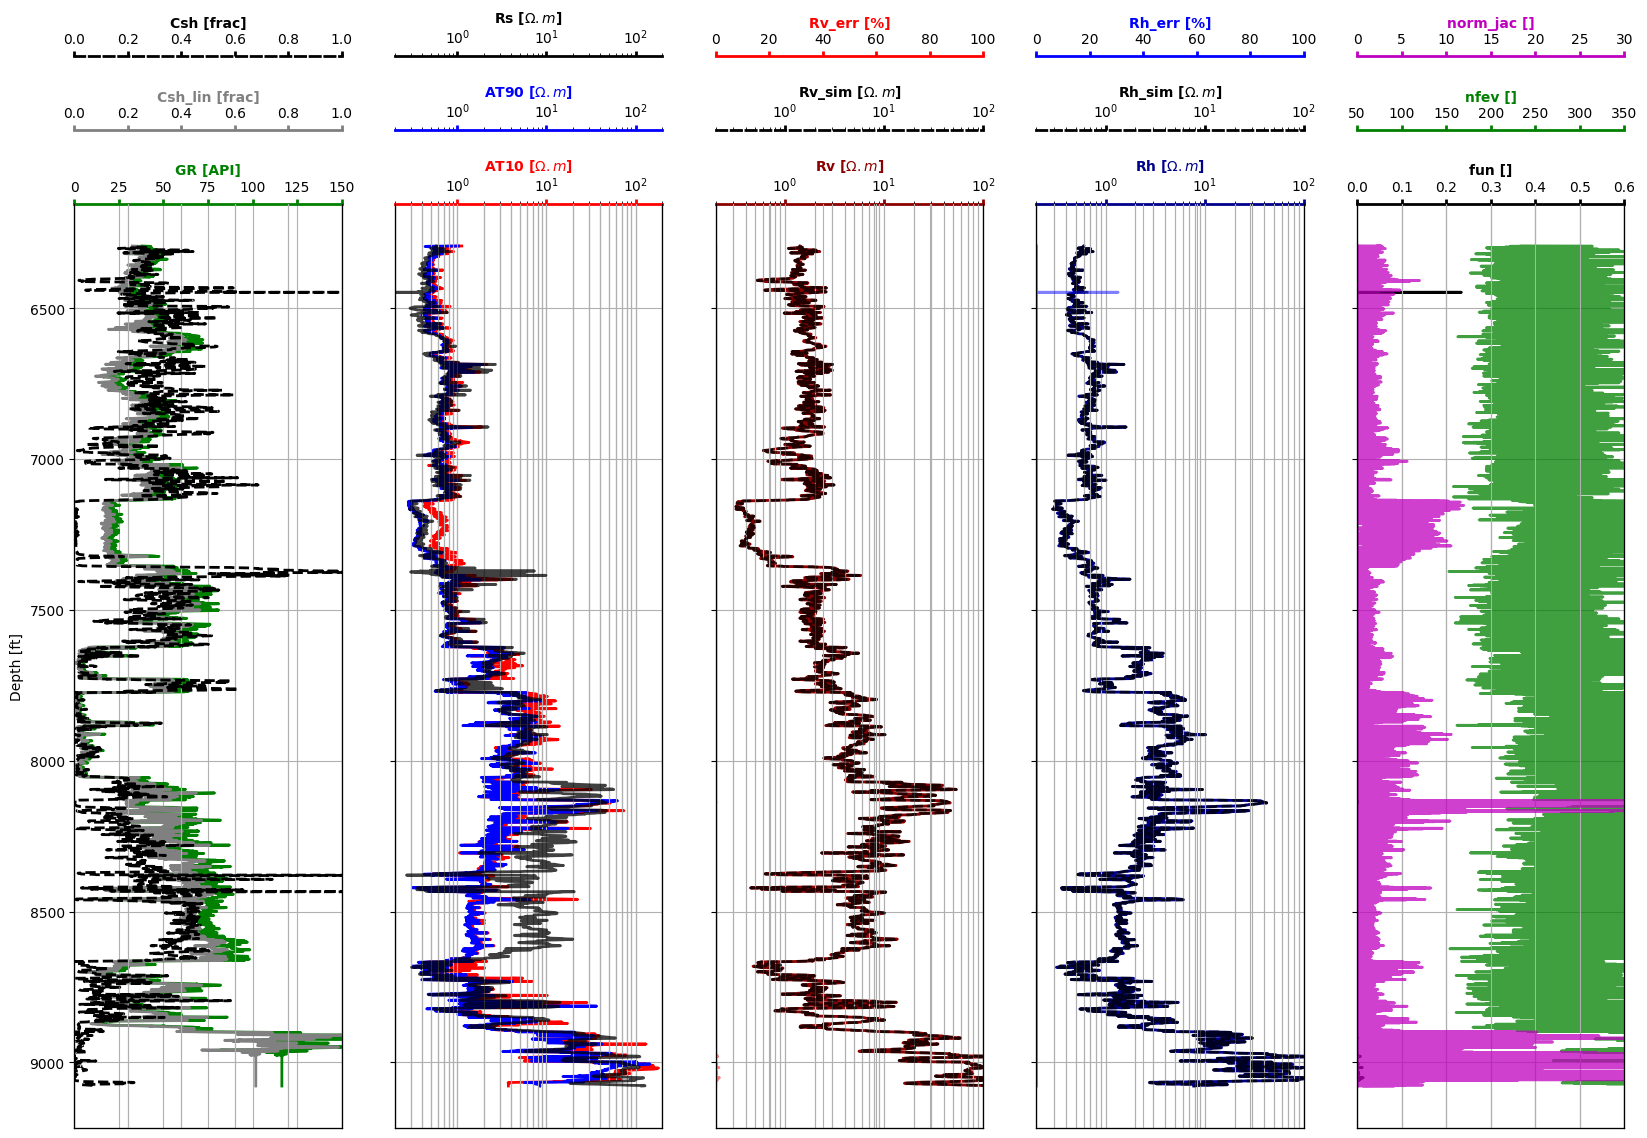

In [5]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

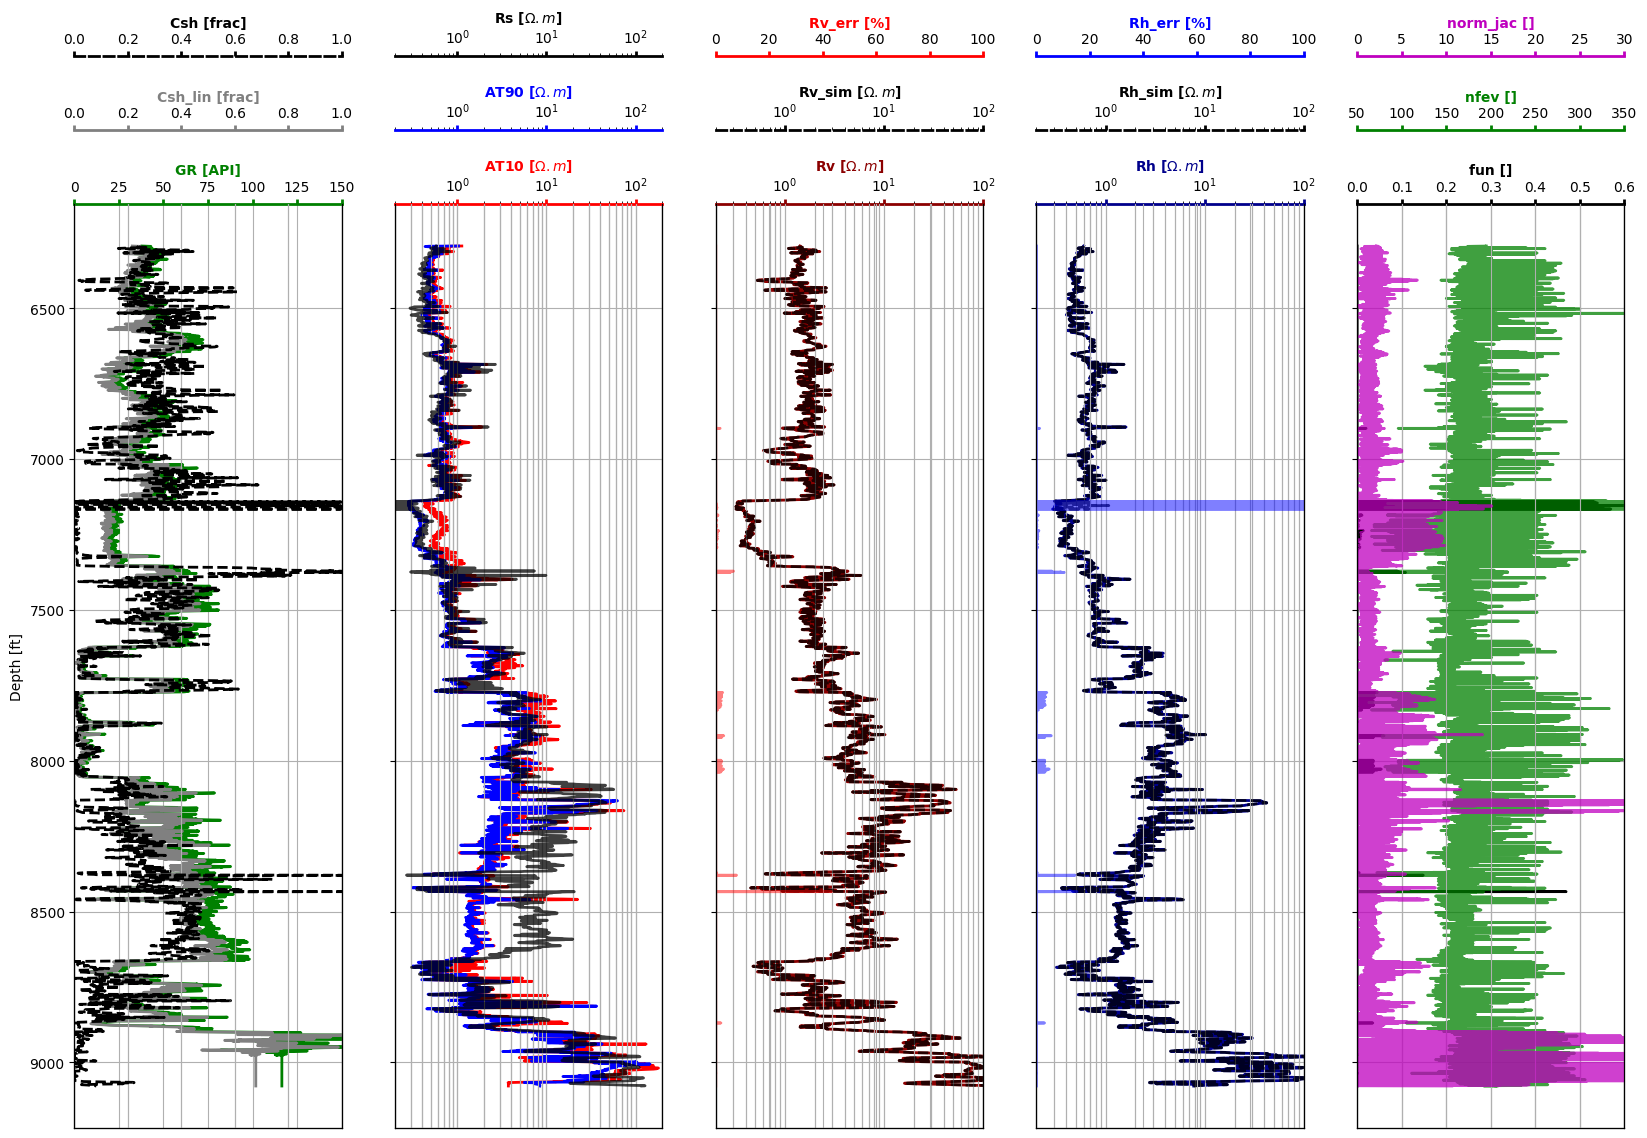

In [39]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [194]:
from torch.utils.data import DataLoader, TensorDataset

In [186]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.1+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [257]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.enc = nn.TransformerEncoderLayer(d_model=2, nhead=2, dim_feedforward=64)
        self.dec = nn.Linear(2,2)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)

        #x = nn.GELU()(self.fc1(x))
        #x = nn.GELU()(self.fc2(x))
        #x = self.fc3(x)
        return x

In [268]:
class PhysicsInformedLoss(torch.nn.Module):
    def forward(self, inputs, outputs, Rvsh=2.8133, Rhsh=0.7746):
        Rv_true, Rh_true = inputs[:,  0], inputs[:,  1]
        Csh,     Rs      = outputs[:, 0], outputs[:, 1]

        Rv_simulated = Csh*Rvsh + (1-Csh)*Rs
        Rh_simulated = 1 / (Csh/Rhsh + (1-Csh)/Rs)

        Rv_err = (Rv_true - Rv_simulated) / Rv_true
        Rh_err = (Rh_true - Rh_simulated) / Rh_true
        
        Rv_loss = torch.mean(Rv_err**2)
        Rh_loss = torch.mean(Rh_err**2)

        return Rv_loss + Rh_loss

In [269]:
def normalize(x, mean, std):
    return (x-mean)/std

def back_normalize(x, mean, std):
    return x*std + mean

In [270]:
res_aniso = case1[['Rv','Rh']]
res_mean, res_std = res_aniso.mean(0).values, res_aniso.std(0).values
data_norm = normalize(res_aniso, res_mean, res_std)

model     = PINNari()
criterion = PhysicsInformedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6)

inputs     = torch.tensor(data_norm.values, dtype=torch.float32)
dataset    = TensorDataset(inputs)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

epochs = 300
for epoch in range(epochs):
    model.train()
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()

In [271]:
Rvsh, Rhsh = 2.8133, 0.7746

y = model(inputs).detach().numpy()
y = back_normalize(y, res_mean, res_std)
csh_pred, rs_pred = y[:,0], y[:,1]

Rv_sim = csh_pred*Rvsh + (1-csh_pred)*rs_pred
Rh_sim = csh_pred/Rhsh + (1-csh_pred)/rs_pred
Rv_err = np.abs((Rv_sim - case1['Rv'].values)/case1['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - case1['Rh'].values)/case1['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rs_pred':rs_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=case1.index)

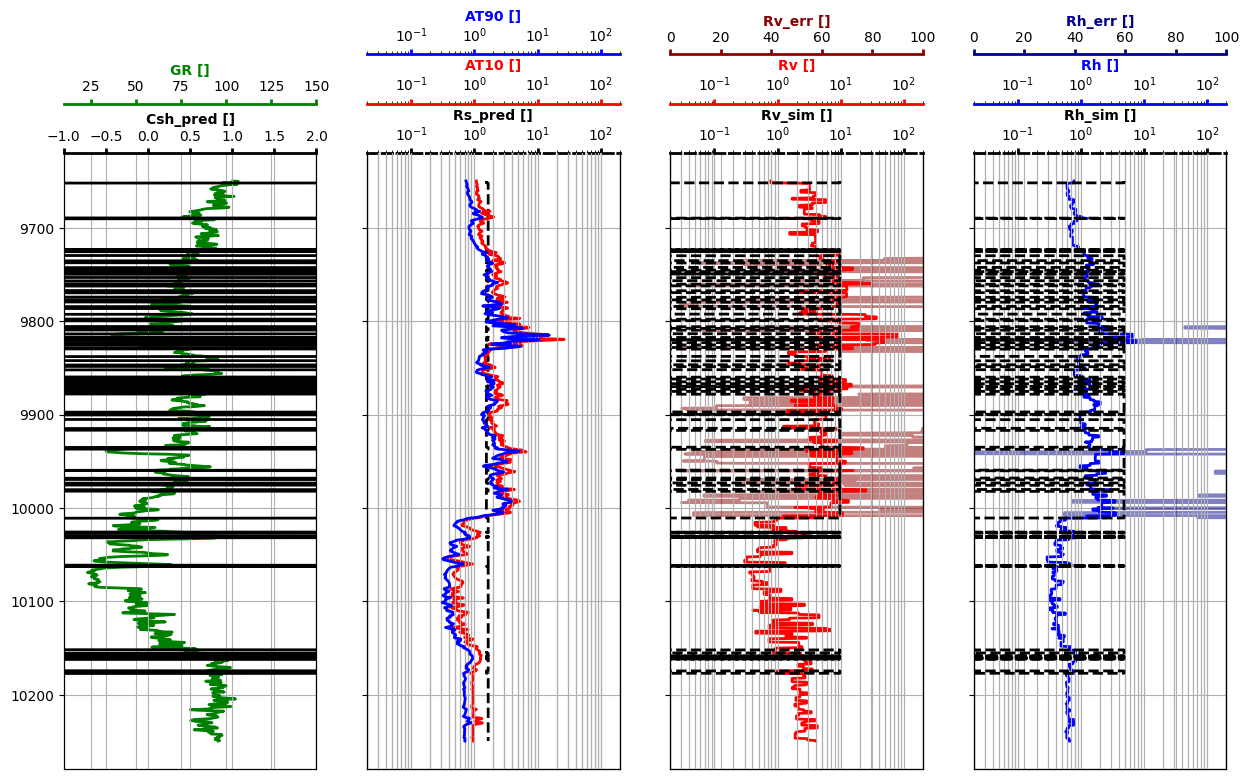

In [272]:
fig, axs = plt.subplots(1, 4, figsize=(15,8), sharey=True)
ax1, ax2, ax3, ax4 = axs

ax11 = ax1.twiny()
ari.plot_curve(ax1, case1, 'GR', 10, 150, 'g', pad=8)
ari.plot_curve(ax11, sol, 'Csh_pred', -1, 2, 'k')

ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax21, case1, 'AT10', 0.02, 200, 'r', semilog=True, pad=8)
ari.plot_curve(ax22, case1, 'AT90', 0.02, 200, 'b', semilog=True, pad=16)
ari.plot_curve(ax2, sol, 'Rs_pred', 0.02, 200, 'k', ls='--', semilog=True)

ax31, ax32 = ax3.twiny(), ax3.twiny()
ari.plot_curve(ax31, case1, 'Rv', 0.02, 200, 'r', semilog=True, pad=8)
ari.plot_curve(ax32, sol, 'Rv_sim', 0.02, 200, 'k', ls='--', semilog=True)
ari.plot_curve(ax3, sol, 'Rv_err', 0, 100, 'darkred', alpha=0.5, pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
ari.plot_curve(ax41, case1, 'Rh', 0.02, 200, 'b', semilog=True, pad=8)
ari.plot_curve(ax42, sol, 'Rh_sim', 0.02, 200, 'k', ls='--', semilog=True)
ari.plot_curve(ax4, sol, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, pad=16)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.show()

***
# END
***